## Complilation with Open MP

In [33]:
!mkdir -p build
!cd build &&  cmake -DUSE_OMP=True -DUSE_CUDA=False -DCMAKE_BUILD_TYPE=Release .. &&  make

-- Traces are activated
-- Configuring done
-- Generating done
-- Build files have been written to: /home/cgomes/ot5/TP_AEVOL/build
Consolidate compiler generated dependencies of target micro_aevol
[  8%] Building CXX object CMakeFiles/micro_aevol.dir/Abstract_ExpManager.cpp.o
[ 16%] Building CXX object CMakeFiles/micro_aevol.dir/ExpManager.cpp.o
[ 25%] Building CXX object CMakeFiles/micro_aevol.dir/AeTime.cpp.o
[ 33%] Building CXX object CMakeFiles/micro_aevol.dir/DnaMutator.cpp.o
[ 41%] Building CXX object CMakeFiles/micro_aevol.dir/MutationEvent.cpp.o
[ 50%] Building CXX object CMakeFiles/micro_aevol.dir/Organism.cpp.o
[ 58%] Building CXX object CMakeFiles/micro_aevol.dir/Stats.cpp.o
[ 66%] Building CXX object CMakeFiles/micro_aevol.dir/Threefry.cpp.o
[ 75%] Building CXX object CMakeFiles/micro_aevol.dir/Dna.cpp.o
[ 83%] Linking CXX static library libmicro_aevol.a
[ 83%] Built target micro_aevol
Consolidate compiler generated dependencies of target micro_aevol_cpu
[ 91%] Building CX

## Performance evaluation

In [ ]:
import os
import subprocess
import glob
import subprocess

nrepeats = 15
nb_threads=6

subfolders = [ f.path for f in os.scandir("simulations_release") if f.is_dir() ]
folder_name = "simulation_" + str(len(subfolders))
os.mkdir("simulations_release/" + folder_name)
os.chdir("./simulations_release/" + folder_name)
print(os.getcwd())
print(folder_name)

for repeat in range(nrepeats):
    args = ("../../build/micro_aevol_cpu", "-T", str(nb_threads),"-R",str(repeat))
    popen = subprocess.Popen(args, stdout=subprocess.PIPE)
    popen.wait()
    
os.chdir("../../")

## Performance analysis

/tmp/ipykernel_3376/4203229038.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  frame = pd.concat(li, axis=0).groupby('Gen').mean()
/tmp/ipykernel_3376/4203229038.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  frame = pd.concat(li, axis=0).groupby('Gen').mean()
/tmp/ipykernel_3376/4203229038.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  frame = pd.concat(li, axis=0).groupby('Gen').mean()
/tmp/ipykerne

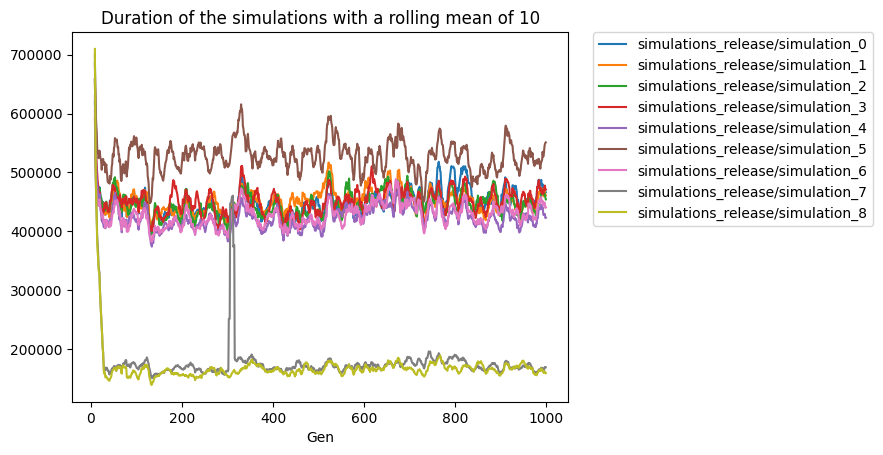

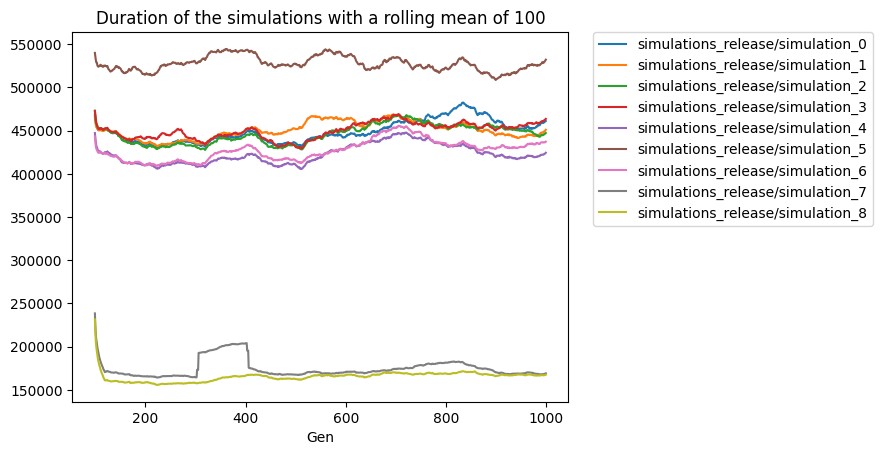

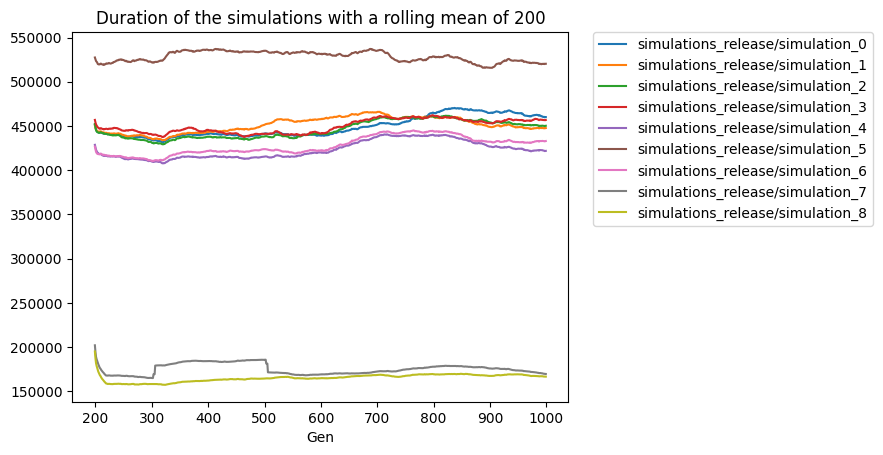

In [2]:
#create a dataframe with the mean of each simulation, with the index being 'Gen"
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

#Change the path to the absolute path of the folder where the project is
ABSOLUTE_PATH = "/home/cgomes/ot5/TP_AEVOL"
os.chdir(ABSOLUTE_PATH)

#read all the simulation folders in the simulations folder
subfolders = [ f.path for f in os.scandir("simulations_release") if f.is_dir() ]
subfolders.sort()

#read all the csv files in each simulation folder
simulations_list = []


for folder in subfolders:
    all_files = glob.glob(folder + "/*.csv")
    li = []
    for filename in all_files:
        df = pd.read_csv(filename, index_col=None, header=0)
        df = df.iloc[1:]
        li.append(df)

    frame = pd.concat(li, axis=0).groupby('Gen').mean()
    simulations_list.append(frame)


for rolling in [10,100,200]:
    for simulation in simulations_list:
        simulation['duration'] = simulation['Duration'].astype(float)
        #create subplot by rolling value

        simulation['duration'].rolling(rolling).mean().plot(label=str(rolling))

        plt.legend(subfolders,bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.title("Duration of the simulations with a rolling mean of " + str(rolling))
    plt.show()
            



# Discussion


## Introduction

Le but de ce projet était d'optimiser le programme qui nous a été fourni. Nous avions plusieurs choix qui s'offraient à nous : nous avons donc décidé de nous concentrer sur l'optimisation CPU avec Open MP. Cette solution a été choisi car nous avons déjà eu l'occasion de travailler avec cette bibliothèque et nous avons donc pu nous appuyer sur nos connaissances, acquises lors de nos cours de programmation parallèle. Nous avons par ailleurs délibérément choisi de ne pas nous concentrer sur l'optimisation GPU : l'installation de CUDA étant assez complexe et nous n'avions pas le temps de nous y intéresser. De plus toutes les machines sur lesquelles nous avons pu tester notre programme n'avaient pas forcément de GPU. En particuler les machines de la salle 208, quand allumées, sont souvent utilisées, rendant les temps de simulations plus aléatoires.

La première étape a été d'analyser le code. Nous avons essayer de comprendre comment il fonctionnait et nous avons chercher quelles optimisations semblaient bonnes. En parallèle de notre analyse du code, nous avons créé ce notebook pour pouvoir compiler et exécuter le code automatiquement tout en ayant une trace de l'exécution et du temps qu'elle a pris. Nous avons repéré plusieurs boucles qui nous paraissaient parallélisables et certains blocs améliorables. Nous avons également étudié les paramètres de compilations qui pouvaient aussi avoir une influence sur les performances.

La majorité de nos tests a été réalisée sur nos machines sous WSL2. Toutes les simulations ont été réalisées par un processeur `Intel I5-11600K` cadencé à 3.90GHz avec 6 coeurs et 12 processeurs logiques.

Nous avons réalisé nos simulations 15 fois avec 6 threads OpenMP pour éviter toute valeur potentiellement faussée.

Tout au long du projet nous avons oscillé entre les résultats de ce Notebook, pour mesurer les performances du programme et les comparer avec les résultats précédents, et les résultats de `Intel Advisor`, qui nous donnait des informations sur le nombre de boucles vectorisées, le temps passé dans chaque fonctions et boucles, et aussi un graphique nous permettant de voir les points du code qui étaient plutot `Memory Bound` ou `Compute Bound`.

Après que le notebook soit fonctionnel, nous avons réalisé plusieurs tests. Nous avons d'abord lancé le programme sans aucune optimisation pour avoir une mesure de base. Par la suite, nous avons ajouté une modification à la fois et nous avons mesuré le temps d'exécution pour savoir si notre optimisation était bonne ou au contraire réduisait les performances. Après plusieurs optimisations, nous avons décidé d'utiliser Intel Advisor pour pouvoir détecter plus précisément les boucles lentes. Cela nous a permis de trouver d'autres optimisations.



## Détails des optimisations

### Simulation_0 :

Version originale sans Open MP (séquentiel)

### Simulation_1 :

- Ajout d'une parallélisation/réduction de `geometric_area` dans les 2 constructeurs :
```
ExpManager::ExpManager(...)
```
avec 
```
#pragma omp parallel for reduction(+:geometric_area)
#pragma omp parallel for
```

Cette réduction nous est apparue rapidement, on a reconnu un calcul d'intégrale qui est facilement parallélisable parce qu'on peut calculer chaque intervalle séparémment. La réduction permet également d'accélérer le calcul en réduisant le nombre d'addition. On a utilisé le procédé vu en TP pour le calcul de pi.

### Simulation_2 :

- Vectorisation des boucles dans 
```
Dna::promoter_at(...)
Dna::terminator_at(...)
```
avec 
```
#pragma omp simd reduction(+:dist_lead)
```
Le vecteur `seq_` a été reconstruit de manière à ne le parcourir que dans un seul sens sans revenir à l'index 0 une fois arrivé au dernier index. Ce nouveau vecteur est : `seq_ext`. Cette modification permet de pouvoir utiliser des `pragma simd` plus des `reduction` lors des opérations effectuées.

Ces modifications ont légèrement améliorés les performances sur les dernières générations.

### Simulation_3 :

- Ajout d'une parallélisation et d'un pragma `simd` dans la fonction 
```
Organism::translate_protein()
```
avec 
```
#pragma omp simd
```

Cette vectorisation nous a été suggérée par `Intel Advisor`.
Cette modification n'a pas eu énormément d'impact sur les performances.

### Simulation_4 :

- Cette simulation a été lancée avec une modification de la fonction :
```
Organism::compute_fitness(...)
```
avec 
```
#pragma omp simd reduction(+:metaerror)
```

La réduction sur la variable `metaerror` ainsi qu'un pragma `simd` pour les opérations sur le tableau nous a permis d'avoir une bonne amélioration sur les performances pour l'ensemble des générations. La vectorisation nous a encore une fois été suggérée par `Intel Advisor`.

### Simulation_5 :

- Ajout de tasks Open MP dans 
```
Organism::look_for_new_promoters_starting_between(...)
```
sur les opérations 
```
#pragma omp parallel {
    #pragma omp single {
        #pragma omp task {
            look_for_new_promoters_starting_after(pos_1);
        }
        #pragma omp task {
            look_for_new_promoters_starting_before(pos_2);
        }
    }
}
```
Ces opérations sont indépendantes et peuvent donc être exécutées en parallèle : les `tasks` d'Open MP nous semblait très bien répondre à cette problématique.
Néanmoins, nous avons observé que les performances étaient largement moins bonnes que sur l'ensemble des simulations précédentes. Nous avons supposé que cette baisse était due aux `tasks` créées qui étaient trop nombreuses par rapport à la taille des opérations, ce qui augmentait le temps. Nous avons donc garder l'implémentation de la `simulation_4`, sans les tasks.


### Simulation_6 :

- Cette simulation est simplement la même que la `simulation_4` après avoir retiré les `tasks`. elle nous a permis de confirmer que cet ajout était bien la cause des pertes de performances. Cette simulation permet aussi de mettre en évidence que malgré le fait de lancer plusieurs fois de suite le programme, nous pouvons quand même avoir des différences de performances, pour une même configuration.


### Simulation_7 :

- Ajout de parallélisation sur les différentes boucles de la fonction 
```
ExpManager::run_a_step()
```
avec 
```
#pragma omp parallel for
```

Ces optimisations ont considérablement amélioré les performances du programme en divisant plus de 2 fois le temps d'éxécution. Ce gros gain de performances a pu être possible car toutes les boucles vont de 0 à `nb_indivs_` qui est égal par défaut à : 
```
nb_indivs_= grid_height * grid_width
```
Ce grand nombre d'opérations indépendantes effectué séquentiellement a pu être largement optimisé avec la parallélisation.


### Simulation_8 :
- Une autre boucle parcourant `nb_indiv_` se trouve dans 
```
ExpManager::run_evolution(...)
```
a été parallélisée avec 
```
#pragma omp parallel for
```

Cette parallélisation permet d'améliorer le temps d'exécution du programme.


# Conclusion

Nous avons réalisé d'autres tests, que nous n'avons pas reporté dans les simulations car peu pertinent, notamment l'ajout de l'option `-ftree-vectorize`, qui aide le compilateur à vectoriser les boucles, mais il semblerait que compiler en version `Release` inclut déjà cette option.

Nous avons aussi essayé de compiler le programmer à l'aide du compilateur Intel `icc`. Ce compilateur permet d'avoir une meilleure description dans Intel Advisor, ainsi que quelques optimisations supplémentaires. Mais nous avons décidé de ne pas l'utiliser pour ce rapport, car plusieurs problèmes ont été rencontrés.

Tout au long du projet nous avons été amené à compiler le programme avec différents modes de compilation, notamment `Release`, `Debug` et le mode par défaut. Le mode `Release` permet d'avoir des performances plus élevées, mais il est plus difficile de débugger le programme, notamment sous `Intel Advisor`. C'est pourquoi nous avons fréquemment utilisé le mode `Debug`. Nous avons aussi utilisé le mode de compilation par défaut parce que nous ne voulions pas insérer des paramètres de compilation que nous ne maîtrisions pas : la documentation de CMake ne précise pas ce qui est utilisé ni en `Release` ni en `Debug`. Cependant, nous nous sommes rendu compte que certains pragmas simd n'étaient pas pris en compte, nous sommes alors passés avec le mode `Release` qui va chercher plus en profondeur à réaliser la vectorisation.

Lors de l'utilisation des pragmas `omp simd`, il nous est apparu que le compilateur ne prenaient pas cette instruction comme une obligation, mais plus comme un indice d'un endroit où une vectorisation pourrait être apppliquée. Selon le mode de compilation la recherche de boucles à vectoriser est plus ou moins poussée.

Au final, nous avons réussi à optimiser le programme en parallélisant les boucles les plus importantes, en utilisant la vectorisation et en utilisant les réductions pour les calculs d'intégrales.

Nous pensons néanmoins que le programme pourrait être encore plus optimisé, en tirant plus partie de la vectorisation. Nous pourrions aussi utiliser la puissance de calcul de la carte graphique pour accélérer le programme, avec par exemple un outil comme `Kokkos`, qui nous permettrait d'optimiser sur CPU ainsi que sur GPU.